In [1]:
import numpy as np
from scipy.ndimage import zoom
from skimage import data, img_as_float, color, exposure
import matplotlib.pyplot as plt

## Define Functions

In [2]:
def get_2d_edges(shape: (tuple, list)) -> np.ndarray:
    nodes = np.arange(np.prod(shape)).reshape(shape)
    edges = np.concatenate(
        (
            np.stack([nodes[:, :-1].ravel(), nodes[:, 1:].ravel()], axis=1),
            np.stack([nodes[:-1, :].ravel(), nodes[1:, :].ravel()], axis=1),
        ),
        axis=0,
    )
    return edges

def branch_cut(phase: np.ndarray, edges: np.ndarray, correlation: np.ndarray = None, max_jump: int = 1, norm: float = 1, scale: float = 2**16 - 1, max_iters: int = 100) -> np.ndarray:
    """
    Perform phase unwrapping using the branch-cut algorithm.

    Args:
        phase (np.ndarray): A 1D array of wrapped phase values with shape (N,).
        edges (np.ndarray): A 2D array of edges connecting the nodes, with shape (M, 2).
        correlation (np.ndarray, optional): A 1D array of correlation values corresponding to each phase value. If None, uniform correlation is assumed. Default is None.
        max_jump (int): The maximum jump step for phase unwrapping. Default is 1.
        norm (float): The p-norm used for calculating the cost function. Default is 1.
        scale (float): The scaling factor used for converting float values to integer weights for OR-Tools. Default is 2**16 - 1.
        max_iters (int): The maximum number of iterations to perform. Default is 100.

    Returns:
        np.ndarray: A 1D array of unwrapped phase values with the same shape as the input phase array.
    """
    import numpy as np
    from ortools.graph.python import max_flow

    def scale_phase(phase):
        return np.round(scale * phase).astype(int)

    def p_norm(x):
        return np.abs(x) ** norm

    def safe_log(x, epsilon=1e-10):
        return np.log(np.maximum(x, epsilon))

    nodes = phase.size
    source = nodes
    sink = nodes + 1

    # extend phase array by two nodes for source and sink
    jumps = np.zeros(shape=(nodes+2), dtype=int)
    
    def energy_estimate(jumps, phase, i, j):
        return np.sum(p_norm(jumps[j] - jumps[i] - phase[i] + phase[j]))

    energy_prev = energy_estimate(jumps, phase, edges[:, 0], edges[:, 1])

    energies = []
    jump_step = max_jump
    while jump_step >= 1:
        iter_count = 0
        while iter_count < max_iters:
            energies.append(energy_prev)
            max_flow_solver = max_flow.SimpleMaxFlow()

            i, j = edges[:, 0], edges[:, 1]
            phase_diff = phase[i] - phase[j]
            phase_res = (jumps[j] - jumps[i]) - phase_diff
            energy_res = p_norm(phase_res)
            energy_res_down = p_norm(phase_res - jump_step)
            energy_res_up   = p_norm(phase_res + jump_step)
            weight = np.maximum(0, (energy_res_up - energy_res) + (energy_res_down - energy_res))
            # Adjust weights based on correlation
            if correlation is not None:
                # untested
                correlation_ij = (correlation[i] + correlation[j])/2
                weight = weight / (-safe_log(correlation_ij))
                del correlation_ij
            del phase_diff, phase_res, i, j

            # add arcs with capacities at once
            max_flow_solver.add_arcs_with_capacity(edges[:, 0], edges[:, 1], scale_phase(weight))
            max_flow_solver.add_arcs_with_capacity(edges[:, 1], edges[:, 0], np.zeros_like(weight))
            del weight

            # simpler but slowly
            # weight_source = np.zeros((nodes))
            # weight_sink   = np.zeros((nodes))
            # for edge_index in range(edges.shape[0]):
            #     u, v = edges[edge_index]
            #     weight_source[u] += max(0, energy_res_up[edge_index] - energy_res[edge_index])
            #     weight_source[v] += max(0, energy_res[edge_index]    - energy_res_up[edge_index])
            #     weight_sink[u]   -= min(0, energy_res_up[edge_index] - energy_res[edge_index])
            #     weight_sink[v]   -= min(0, energy_res[edge_index]    - energy_res_up[edge_index])

            # more tricky and faster
            weight_source = np.zeros(nodes)
            weight_sink = np.zeros(nodes)            
            u = edges[:, 0]
            v = edges[:, 1]
            diff_up_down = energy_res_up - energy_res
            diff_down_up = energy_res - energy_res_up
            # Separate positive and negative differences
            positive_diff_up_down = np.maximum(0, diff_up_down)
            negative_diff_up_down = np.minimum(0, diff_up_down)
            positive_diff_down_up = np.maximum(0, diff_down_up)
            negative_diff_down_up = np.minimum(0, diff_down_up)
            # Apply updates
            np.add.at(weight_source, u, positive_diff_up_down)
            np.add.at(weight_source, v, positive_diff_down_up)
            np.add.at(weight_sink, u, -negative_diff_up_down)
            np.add.at(weight_sink, v, -negative_diff_down_up)
            del energy_res, energy_res_up, energy_res_down, diff_up_down, diff_down_up

            # connections from source node to all nodes
            source_arcs = np.column_stack((np.full(nodes, source), np.arange(nodes)))
            # connections from all nodes to sink node
            sink_arcs = np.column_stack((np.arange(nodes), np.full(nodes, sink)))

            # add source and sink arcs capacities
            max_flow_solver.add_arcs_with_capacity(source_arcs[:, 0], source_arcs[:, 1], scale_phase(weight_source))
            max_flow_solver.add_arcs_with_capacity(sink_arcs[:, 0],   sink_arcs[:, 1],   scale_phase(weight_sink))
            del weight_source, weight_sink

            status = max_flow_solver.solve(source, sink)
            if status != max_flow.SimpleMaxFlow.OPTIMAL:
                raise Exception("There was an issue with the max flow computation.")
            source_nodes = max_flow_solver.get_source_side_min_cut()
            del max_flow_solver
            
            jumps[source_nodes] += jump_step

            energy = energy_estimate(jumps, phase, edges[:, 0], edges[:, 1])

            print ('jump_step, iter_count, energy - energy_prev', jump_step, iter_count, energy - energy_prev)
            if energy < energy_prev:
                energy_prev = energy
                iter_count += 1
            else:
                jumps[source_nodes] -= jump_step
                break

        # define jump_steps using geometric progression
        jump_step //= 2

    # exclude source and sink nodes
    return jumps[:-2]

In [3]:
# example usage with synthetic data
phase = np.array([1.1, 2.2, 3.3, 4.4, 6])
edges = np.array([[0, 1], [1, 2], [2, 3], [3, 4]])
result = branch_cut(phase, edges, max_jump=1)
print(result)

phase = np.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 9, 7, 9, 3, 2, 3, 8, 4, 6])
edges = np.array([
    [0, 1], [0, 2], [1, 2], [1, 3], [2, 4], [3, 4], [3, 5], [4, 6], [5, 6], [5, 7],
    [6, 8], [7, 8], [7, 9], [8, 10], [9, 10], [9, 11], [10, 12], [11, 12], [11, 13], [12, 14],
    [13, 14], [13, 15], [14, 16], [15, 16], [15, 17], [16, 18], [17, 18], [17, 19], [18, 19]
])
result = branch_cut(phase, edges, max_jump=1)
print(result)

jump_step, iter_count, energy - energy_prev 1 0 -1.0000000000000004
jump_step, iter_count, energy - energy_prev 1 1 -1.0
jump_step, iter_count, energy - energy_prev 1 2 -1.0
jump_step, iter_count, energy - energy_prev 1 3 -1.0
jump_step, iter_count, energy - energy_prev 1 4 -0.1999999999999993
jump_step, iter_count, energy - energy_prev 1 5 0.0
[5 4 3 2 0]
jump_step, iter_count, energy - energy_prev 1 0 -16
jump_step, iter_count, energy - energy_prev 1 1 -16
jump_step, iter_count, energy - energy_prev 1 2 -16
jump_step, iter_count, energy - energy_prev 1 3 -12
jump_step, iter_count, energy - energy_prev 1 4 -9
jump_step, iter_count, energy - energy_prev 1 5 -8
jump_step, iter_count, energy - energy_prev 1 6 -5
jump_step, iter_count, energy - energy_prev 1 7 -2
jump_step, iter_count, energy - energy_prev 1 8 0
[6 8 5 8 4 0 7 3 4 6 4 0 2 0 6 7 6 1 5 3]


## Small Image Unwrap

(300, 451)


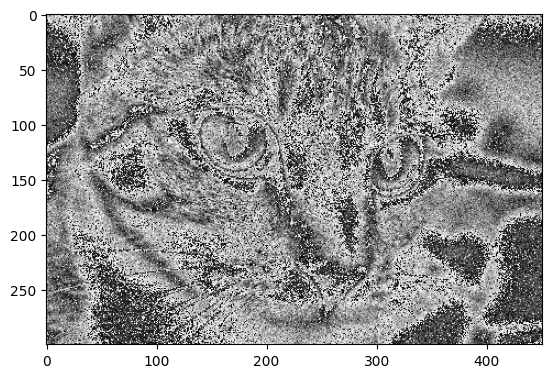

In [4]:
# Load an image as a floating-point grayscale
image = color.rgb2gray(img_as_float(data.chelsea()))
# Scale the image to [0, 4*pi]
image = exposure.rescale_intensity(image, out_range=(0, 4 * np.pi)) + np.random.randn(*image.shape) * 0.3 * np.pi

image_rescaled = zoom(image, zoom=1, order=3)  # order=3 uses cubic interpolation
print(image_rescaled.shape)

# Create a phase-wrapped image in the interval [-pi, pi)
image_wrapped = np.angle(np.exp(1j * image_rescaled))

plt.imshow(image_wrapped, cmap='gray')

jump_step, iter_count, energy - energy_prev 1 0 -20465.909827850977
jump_step, iter_count, energy - energy_prev 1 1 -918.9051674285729
CPU times: user 702 ms, sys: 26.1 ms, total: 728 ms
Wall time: 413 ms


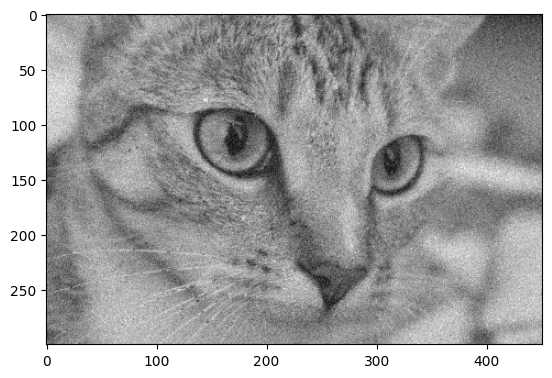

In [5]:
%%time
phase = image_wrapped
edges = get_2d_edges(phase.shape)
jumps = branch_cut(phase.ravel() / (2 * np.pi), edges, max_iters=2)
unwrap = (jumps * (2 * np.pi)).reshape(phase.shape) + phase
plt.imshow(unwrap, cmap='gray')

CPU times: user 816 ms, sys: 86 ms, total: 902 ms
Wall time: 877 ms


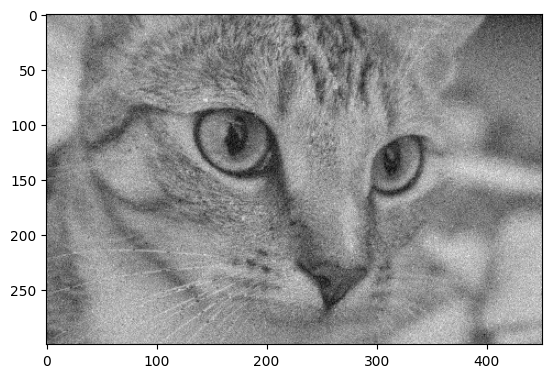

In [6]:
%%time
import xarray as xr
from pygmtsar import Stack
def get_subswath(*args, **kwargs):
    return 0
Stack.get_subswath = get_subswath
def get_reference(*args, **kwargs):
    return None
Stack.get_reference = get_reference
class PRM():
    filename = 'filename'
def _PRM(*args, **kwargs):
    return PRM()
Stack.PRM = _PRM

stack = Stack('tmp', drop_if_exists=True)
unwrap_snaphu = stack.unwrap_snaphu(xr.DataArray(image_wrapped, dims=['y', 'x']).chunk(-1)).compute().phase
plt.imshow(unwrap_snaphu, cmap='gray')

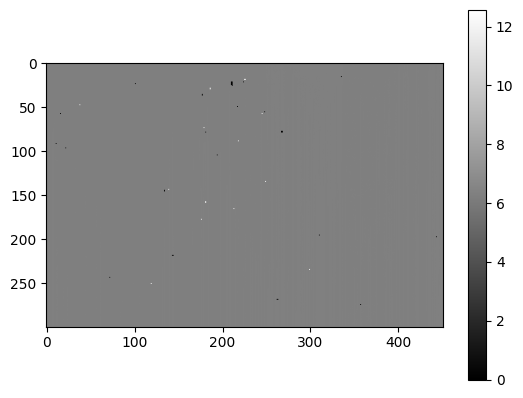

In [7]:
plt.imshow(unwrap - unwrap_snaphu, cmap='gray')
plt.colorbar()

## Larger Image Unwrap

(2400, 3608)


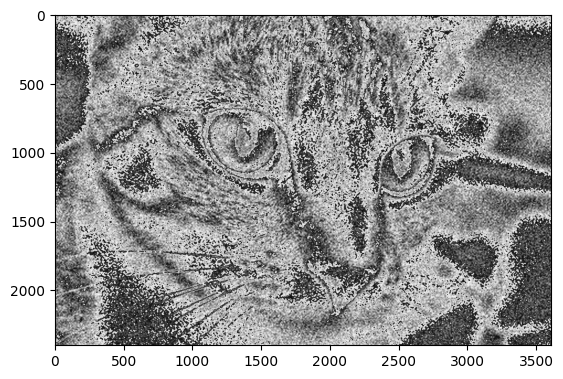

In [8]:
# Load an image as a floating-point grayscale
image = color.rgb2gray(img_as_float(data.chelsea()))
# Scale the image to [0, 4*pi]
image = exposure.rescale_intensity(image, out_range=(0, 4 * np.pi)) + np.random.randn(*image.shape) * 0.3 * np.pi

image_rescaled = zoom(image, zoom=8, order=3)  # order=3 uses cubic interpolation
print(image_rescaled.shape)

# Create a phase-wrapped image in the interval [-pi, pi)
image_wrapped = np.angle(np.exp(1j * image_rescaled))

plt.imshow(image_wrapped, cmap='gray')

jump_step, iter_count, energy - energy_prev 1 0 -357743.0472895342
jump_step, iter_count, energy - energy_prev 1 1 -26064.923966592178
CPU times: user 1min 25s, sys: 3.64 s, total: 1min 29s
Wall time: 1min 30s


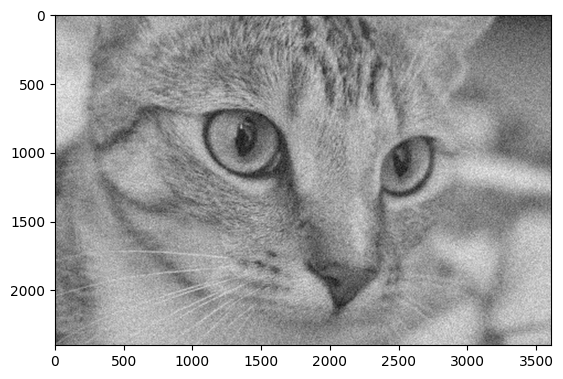

In [9]:
%%time
phase = image_wrapped
edges = get_2d_edges(phase.shape)
jumps = branch_cut(phase.ravel() / (2 * np.pi), edges, max_jump=1, max_iters=2)
unwrap = (jumps * (2 * np.pi)).reshape(phase.shape) + phase
plt.imshow(unwrap, cmap='gray')

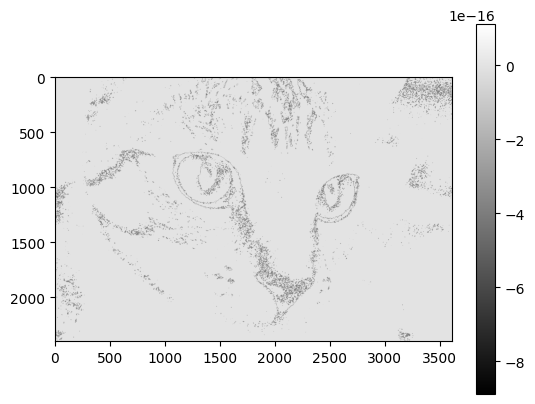

In [10]:
plt.imshow(unwrap - image_rescaled + 0*np.pi, cmap='gray')
plt.colorbar()

CPU times: user 101 ms, sys: 44.9 ms, total: 146 ms
Wall time: 2min 41s


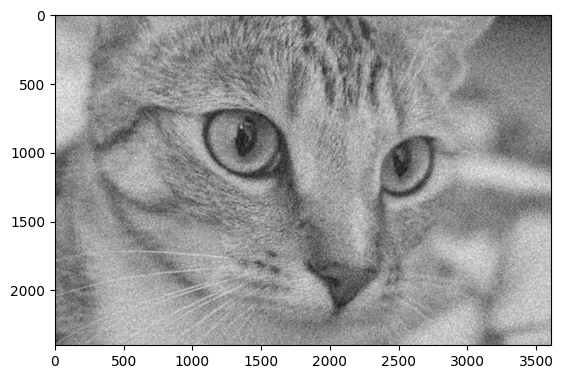

In [11]:
%%time
import xarray as xr
from pygmtsar import Stack
def get_subswath(*args, **kwargs):
    return 0
Stack.get_subswath = get_subswath
def get_reference(*args, **kwargs):
    return None
Stack.get_reference = get_reference
class PRM():
    filename = 'filename'
def _PRM(*args, **kwargs):
    return PRM()
Stack.PRM = _PRM

stack = Stack('tmp', drop_if_exists=True)
unwrap_snaphu = stack.unwrap_snaphu(xr.DataArray(image_wrapped, dims=['y', 'x']).chunk(-1)).compute().phase
plt.imshow(unwrap_snaphu, cmap='gray')
#Wall time: 2min 36s

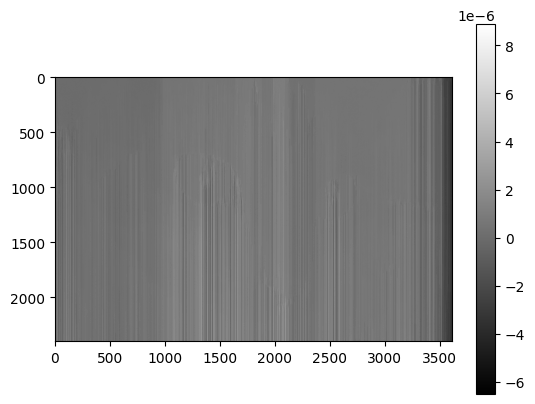

In [12]:
plt.imshow(unwrap_snaphu - image_rescaled + 2*np.pi, cmap='gray')
plt.colorbar()
#np.min(unwrap - rescaled_image), np.max(unwrap - rescaled_image)

In [13]:
np.sqrt(np.sum((unwrap - image_rescaled + 0*np.pi)**2)), np.sqrt(np.sum((unwrap_snaphu - image_rescaled + 2*np.pi)**2))
#(2.746668051025856e-13,<xarray.DataArray 'phase' ()> Size: 8B array(0.00447384)) 2 iters

(2.7395388436691664e-13,
 <xarray.DataArray 'phase' ()> Size: 8B
 array(0.0035271))

## Comparision Branch-Cut vs SNAPHU

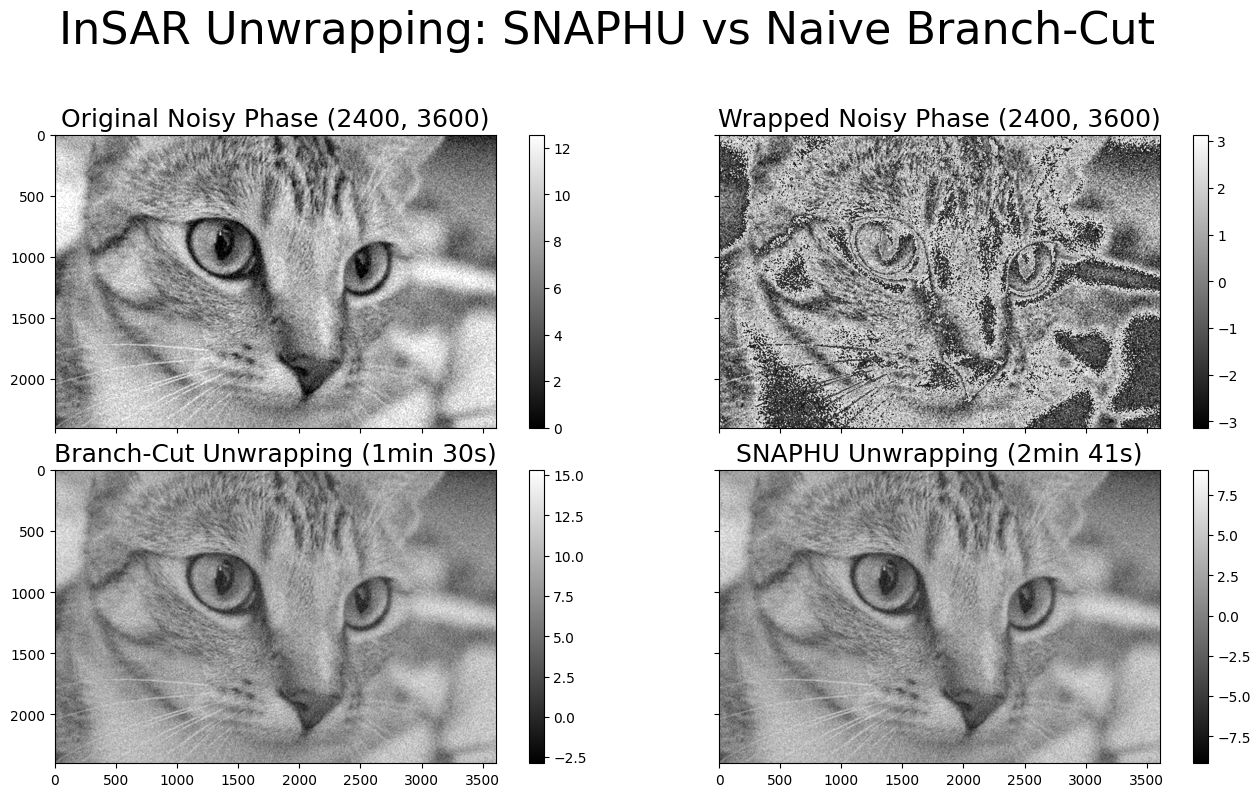

In [16]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[14,8])
ax = ax.ravel()

fig.colorbar(ax[0].imshow(image_rescaled, cmap='gray', vmin=0, vmax=4 * np.pi), ax=ax[0])
ax[0].set_title('Original Noisy Phase (2400, 3600)', fontsize=18)

fig.colorbar(ax[1].imshow(image_wrapped, cmap='gray', vmin=-np.pi, vmax=np.pi),
             ax=ax[1])
ax[1].set_title('Wrapped Noisy Phase (2400, 3600)', fontsize=18)

fig.colorbar(ax[2].imshow(unwrap, cmap='gray'), ax=ax[2])
ax[2].set_title('Branch-Cut Unwrapping (1min 30s)', fontsize=18)

fig.colorbar(ax[3].imshow(unwrap_snaphu, cmap='gray'), ax=ax[3])
ax[3].set_title('SNAPHU Unwrapping (2min 41s)', fontsize=18)

plt.suptitle('InSAR Unwrapping: SNAPHU vs Naive Branch-Cut\n', fontsize=32)
plt.tight_layout()
plt.show()